# Reinforcement Learning–Inspired Modeling for Concrete Strength Prediction
### From Classical Machine Learning to Offline Reinforcement Learning


## 1. Problem Understanding

### Engineering Context

Concrete compressive strength is a critical indicator of construction quality and safety.
It determines whether a concrete structure can withstand mechanical loads over time.

In civil engineering practice, measuring compressive strength requires:
- Producing concrete samples
- Letting them cure for several days or weeks
- Performing destructive laboratory tests

These procedures are costly, time-consuming, and not always feasible at scale.

### Machine Learning Perspective

The **Concrete Compressive Strength Dataset** from the UCI Machine Learning Repository
contains experimental data describing concrete mixtures and their measured strength.

Each sample represents:
- A **state of the system**: material composition and curing age
- A **measured outcome**: compressive strength (MPa)

The classical machine learning objective is:
> Predict the compressive strength from the mixture composition.

### Project Objective

This project goes beyond standard regression and explores:
- Classical Machine Learning baselines
- A **reinforcement learning–inspired formulation**
- Q-learning with tree-based models
- Explainability

### Success Metrics

We evaluate models using:
- **Mean Absolute Error (MAE)** for regression accuracy
- **Stability across models**
- **Interpretability**


In [2]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
# Load Concrete Compressive Strength dataset (UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"

df = pd.read_excel(url)

df.columns = [
    "cement", "slag", "fly_ash", "water", "superplasticizer",
    "coarse_aggregate", "fine_aggregate", "age", "strength"
]

df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Dataset Description

Each observation corresponds to one concrete mixture.

**Input features (state variables):**
1. Cement (kg/m³)
2. Blast Furnace Slag (kg/m³)
3. Fly Ash (kg/m³)
4. Water (kg/m³)
5. Superplasticizer (kg/m³)
6. Coarse Aggregate (kg/m³)
7. Fine Aggregate (kg/m³)
8. Age (days)

**Target variable:**
- Concrete compressive strength (MPa)



In [4]:
df.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [5]:
df.isnull().sum()

,0
cement,0
slag,0
fly_ash,0
water,0
superplasticizer,0
coarse_aggregate,0
fine_aggregate,0
age,0
strength,0


## 3. Data Preparation

We split the dataset into training and test sets.

Important principle:
> All data-driven decisions (thresholds, statistics) must be computed **only on the training set**
to avoid data leakage.


In [6]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

train_df.shape, test_df.shape


((824, 9), (206, 9))

## 4. Classical Machine Learning Baselines

Before introducing reinforcement learning ideas, we establish strong supervised learning baselines.

These models serve as:
- Reference points
- Performance benchmarks
- Scientific justification for more advanced approaches


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [8]:
X_train = train_df.drop("strength", axis=1).values
y_train = train_df["strength"].values

X_test = test_df.drop("strength", axis=1).values
y_test = test_df["strength"].values


In [9]:
baseline = RandomForestRegressor(n_estimators=300)
baseline.fit(X_train, y_train)

baseline_preds = baseline.predict(X_test)
baseline_mae = mean_absolute_error(y_test, baseline_preds)

baseline_mae

3.8263518903313516

### Baseline Interpretation

- Linear models provide a simple reference
- Tree-based models (Random Forest, Gradient Boosting) capture non-linear interactions
- These results motivate exploring alternative formulations such as reinforcement learning


## 5. Reinforcement Learning Reformulation

Although the dataset is static, we reinterpret the prediction task as an
**offline reinforcement learning problem** in a one-step decision setting.

This formulation is equivalent to a **contextual bandit** or a **single-step MDP**.

### RL Components

- **State (s):**
  Concrete mixture features:
  cement, slag, fly ash, water, superplasticizer,
  coarse aggregate, fine aggregate, and curing age.

- **Action (a):**
  A **continuous-valued prediction** of compressive strength (MPa),
  discretized into a fine action grid for optimization.

- **Reward (r):**
  A negative prediction error that encourages accurate decisions:

  \[
  r(s, a) = - (y_{\text{true}} - a)^2
  \]

  This reward function penalizes large errors more strongly
  and provides a smooth learning signal.

### Interpretation

In this formulation, the agent selects a real-valued action (strength prediction)
that maximizes expected reward for a given concrete mixture.
No sequential transitions are involved, making this an **offline, one-step RL problem**.

This approach bridges classical regression and reinforcement learning by framing
prediction as a decision-making process.


In [10]:
num_actions = 50
action_list = np.linspace(
    df["strength"].min(),
    df["strength"].max(),
    num_actions
)

In [11]:
X_train_states = train_df.drop("strength", axis=1).values
y_train = train_df["strength"].values

errs = (train_df["strength"].std())**2

SA_train = []
R_train = []

for s, true_y in zip(X_train_states, y_train):
    for a in action_list:
        sa = np.append(s, a)

        #Squared error
        reward = -((true_y - a)**2) / errs

        SA_train.append(sa)
        R_train.append(reward)

X_train_sa = np.array(SA_train)
train_rewards = np.array(R_train)

## 6. Q-learning with XGBoost

We approximate the action-value function:

\[
Q(s, a) \approx \mathbb{E}[r \mid s, a]
\]

which represents the expected reward for choosing action \(a\)
(predicted strength) in state \(s\) (concrete mixture).

Because both the state and action spaces are continuous and non-linear,
we use **XGBoost**, a gradient-boosted decision tree ensemble,
as a function approximator for the Q-function.

This choice provides:
- Strong performance on tabular data
- Non-linear decision boundaries
- Built-in feature importance and interpretability

The learned policy is obtained by selecting, for each state,
the action that maximizes the predicted Q-value.


In [12]:
from xgboost import XGBRegressor

In [13]:
model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train_sa, train_rewards)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=600,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
def agent_action(model, state):
    qvals = []

    for a in action_list:
        sa = np.append(state, a).reshape(1, -1)
        q = model.predict(sa)[0]
        qvals.append(q)

    best_index = np.argmax(qvals)
    return action_list[best_index]

In [15]:
X_test_states = test_df.drop("strength", axis=1).values
y_test = test_df["strength"].values

preds = []

for s in X_test_states:
    a = agent_action(model, s)
    preds.append(a)

mae = mean_absolute_error(y_test, preds)
mae

3.7917981253460837

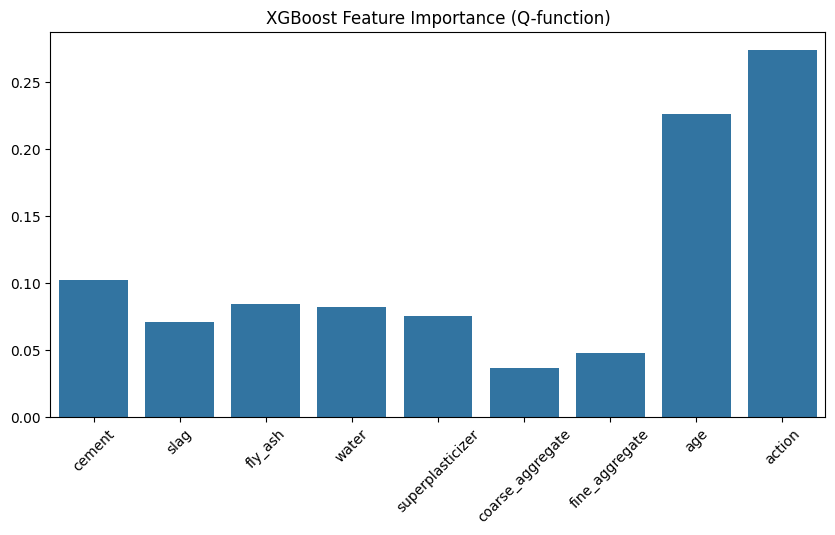

In [16]:
importances = model.feature_importances_
feature_names = df.columns[:-1].tolist() + ["action"]

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_names, y=importances)
plt.xticks(rotation=45)
plt.title("XGBoost Feature Importance (Q-function)")
plt.show()


### Inspecting the Learned Q-function Structure

To better understand how the Q-function is approximated,
we visualize one of the trees inside the XGBoost ensemble.
This provides insight into how state variables and actions
interact in the decision process.


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


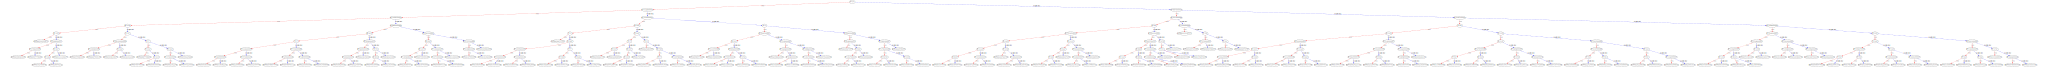

In [17]:
from xgboost import to_graphviz

graph = to_graphviz(model, num_trees=0, max_depth=3)
graph


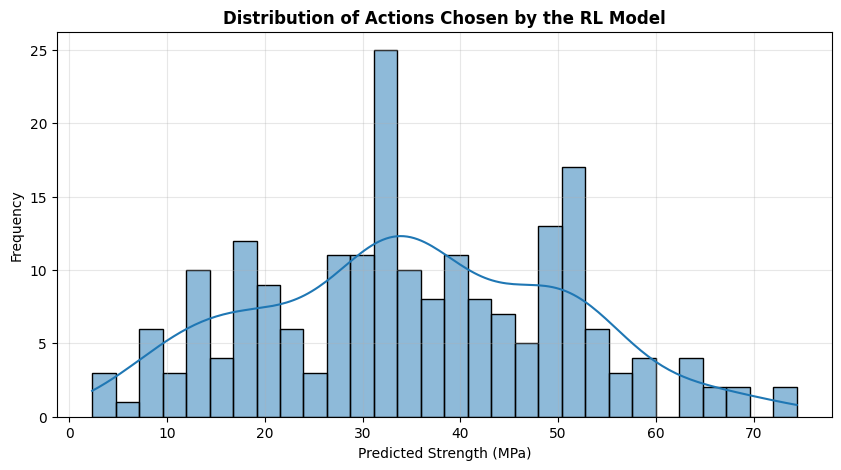

In [18]:
chosen_actions = []

for s in X_test_states:
    a = agent_action(model, s)
    chosen_actions.append(a)

plt.figure(figsize=(10, 5))
sns.histplot(
    chosen_actions,
    bins=30,
    kde=True
)
plt.title("Distribution of Actions Chosen by the RL Model", fontweight="bold")
plt.xlabel("Predicted Strength (MPa)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

Figure: Distribution of continuous strength values selected by the RL policy on the test set. The histogram and KDE highlight how the agent adapts its predictions across the strength range rather than converging to a single value.

/tmp/ipython-input-1673188095.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax6.boxplot([errors_rl, errors_baseline], labels=["RL", "Baseline"])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
 

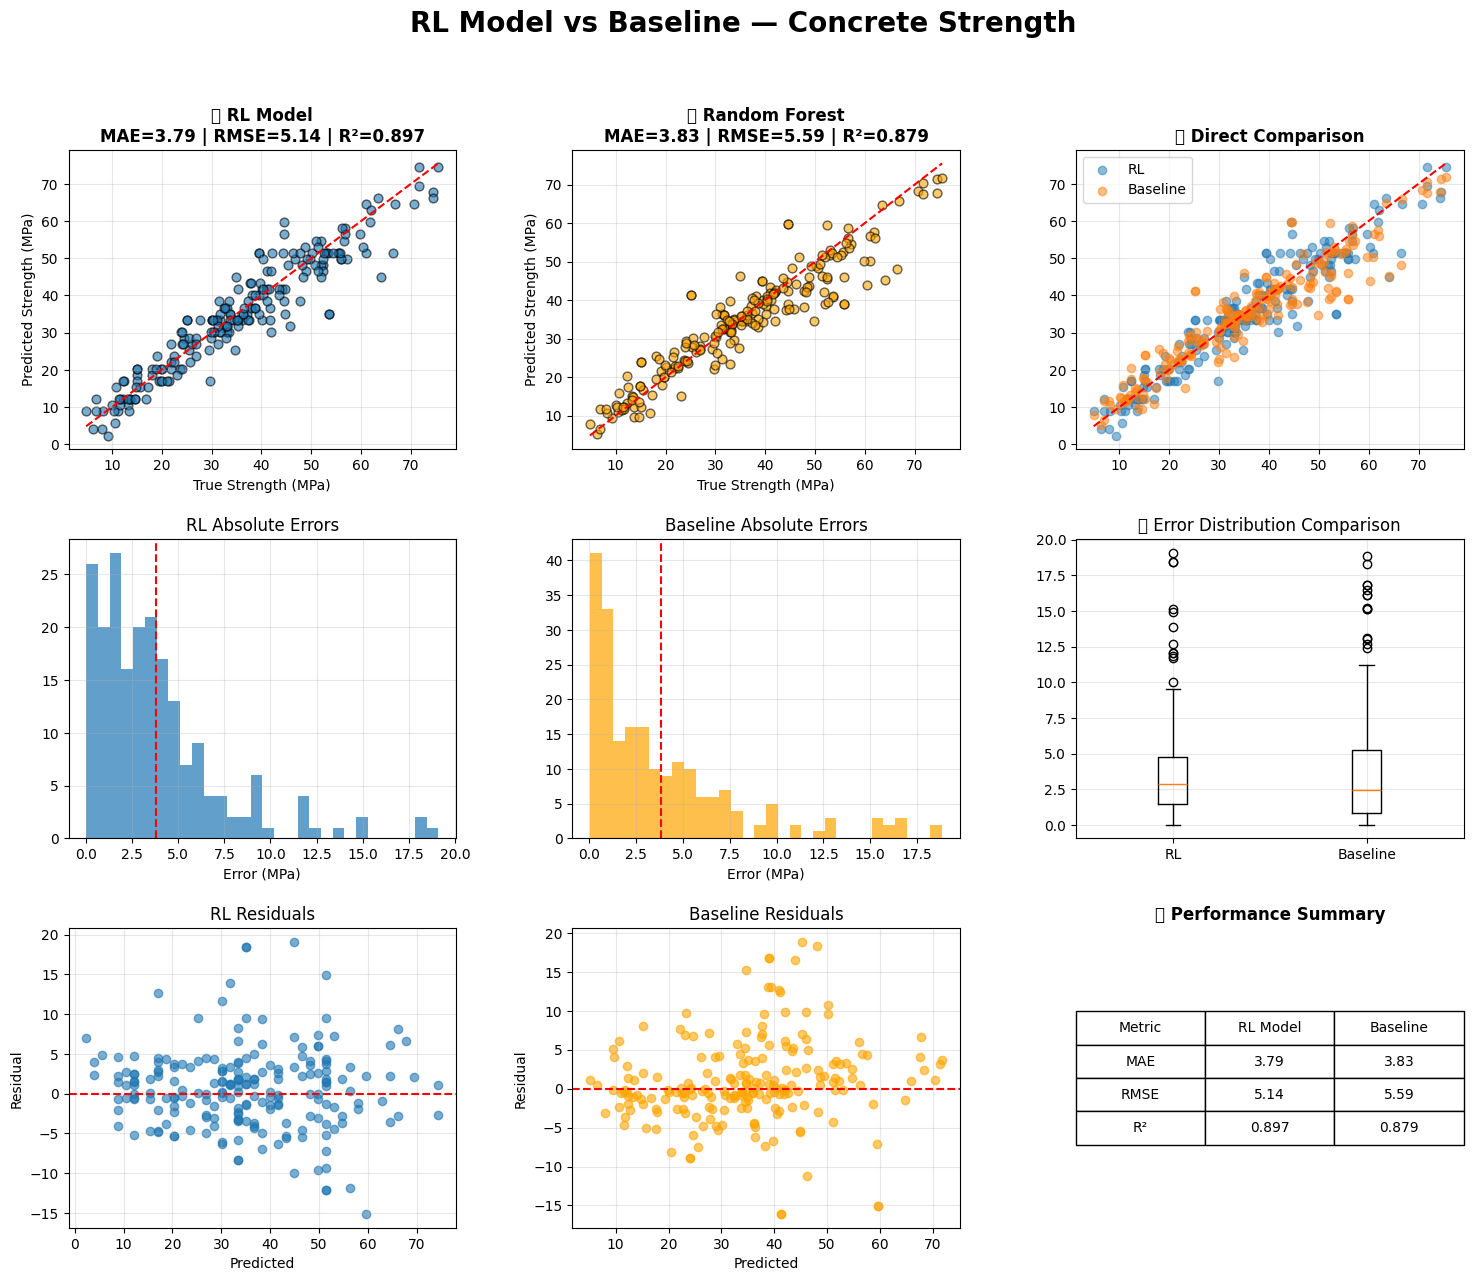

In [19]:
# === RL Agent metrics ===
rl_preds = np.array(preds)
rl_mae  = mean_absolute_error(y_test, rl_preds)
rl_rmse = np.sqrt(mean_squared_error(y_test, rl_preds))
rl_r2   = r2_score(y_test, rl_preds)

# === Baseline metrics ===
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
baseline_r2   = r2_score(y_test, baseline_preds)
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(18, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('RL Model vs Baseline — Concrete Strength', fontsize=20, fontweight='bold')

# ============================================================
# LIGNE 1 — PRÉDICTIONS
# ============================================================

# RL Agent
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, rl_preds, alpha=0.6, s=40, edgecolors='black')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax1.set_title(
    f'🤖 RL Model\nMAE={rl_mae:.2f} | RMSE={rl_rmse:.2f} | R²={rl_r2:.3f}',
    fontweight='bold'
)
ax1.set_xlabel("True Strength (MPa)")
ax1.set_ylabel("Predicted Strength (MPa)")
ax1.grid(alpha=0.3)

# Baseline
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test, baseline_preds, alpha=0.6, s=40, edgecolors='black', color='orange')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax2.set_title(
    f'🌳 Random Forest\nMAE={baseline_mae:.2f} | RMSE={baseline_rmse:.2f} | R²={baseline_r2:.3f}',
    fontweight='bold'
)
ax2.set_xlabel("True Strength (MPa)")
ax2.set_ylabel("Predicted Strength (MPa)")
ax2.grid(alpha=0.3)

# Comparaison
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_test, rl_preds, label="RL", alpha=0.5)
ax3.scatter(y_test, baseline_preds, label="Baseline", alpha=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
ax3.set_title("📊 Direct Comparison", fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# ============================================================
# LIGNE 2 — ERREURS
# ============================================================

errors_rl = np.abs(y_test - rl_preds)
errors_baseline = np.abs(y_test - baseline_preds)

ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(errors_rl, bins=30, alpha=0.7)
ax4.axvline(errors_rl.mean(), color='red', linestyle='--')
ax4.set_title("RL Absolute Errors")
ax4.set_xlabel("Error (MPa)")
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(errors_baseline, bins=30, alpha=0.7, color='orange')
ax5.axvline(errors_baseline.mean(), color='red', linestyle='--')
ax5.set_title("Baseline Absolute Errors")
ax5.set_xlabel("Error (MPa)")
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.boxplot([errors_rl, errors_baseline], labels=["RL", "Baseline"])
ax6.set_title("📦 Error Distribution Comparison")
ax6.grid(alpha=0.3)

# ============================================================
# LIGNE 3 — RÉSIDUS
# ============================================================

ax7 = fig.add_subplot(gs[2, 0])
ax7.scatter(rl_preds, y_test - rl_preds, alpha=0.6)
ax7.axhline(0, color='red', linestyle='--')
ax7.set_title("RL Residuals")
ax7.set_xlabel("Predicted")
ax7.set_ylabel("Residual")
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(baseline_preds, y_test - baseline_preds, alpha=0.6, color='orange')
ax8.axhline(0, color='red', linestyle='--')
ax8.set_title("Baseline Residuals")
ax8.set_xlabel("Predicted")
ax8.set_ylabel("Residual")
ax8.grid(alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary = [
    ["Metric", "RL Model", "Baseline"],
    ["MAE", f"{rl_mae:.2f}", f"{baseline_mae:.2f}"],
    ["RMSE", f"{rl_rmse:.2f}", f"{baseline_rmse:.2f}"],
    ["R²", f"{rl_r2:.3f}", f"{baseline_r2:.3f}"],
]

table = ax9.table(cellText=summary, loc='center', cellLoc='center')
table.scale(1, 2)
ax9.set_title("📋 Performance Summary", fontweight='bold')

plt.show()

### Policy Evaluation Without Classification

Because the RL agent outputs continuous-valued actions rather than discrete classes,
classical confusion matrices are not applicable.

Instead, model performance is evaluated using:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Residual analysis
- Error distributions

These metrics provide a more faithful assessment of policy quality
in a continuous-action setting.


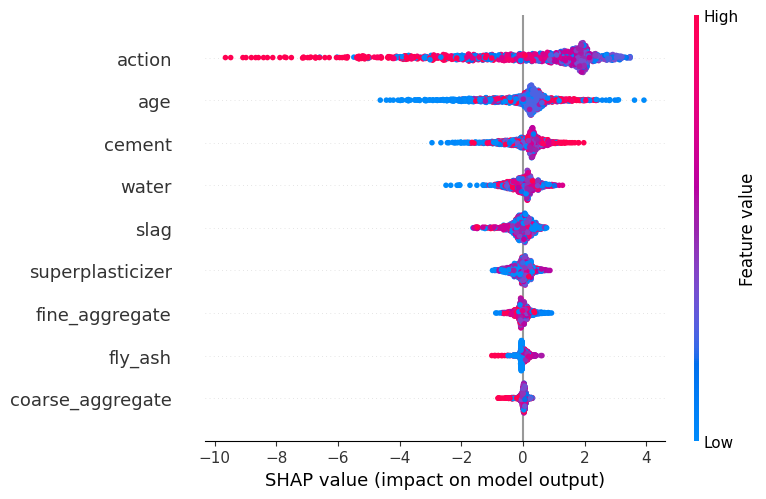

In [20]:
import shap

# Subsample states and actions for SHAP analysis (efficiency)
n_states = 50
n_actions = 20

states_subset = X_test_states[:n_states]
actions_subset = np.linspace(
    df["strength"].min(),
    df["strength"].max(),
    n_actions
)

# Build the SHAP explainer for the model
explainer = shap.Explainer(model)

# Prepare the input data for SHAP (state + action pairs)
X_shap = []

# Create (state, action) pairs for SHAP analysis
for s in states_subset:
    for a in actions_subset:
        sa = np.append(s, a)  # Append action to state
        X_shap.append(sa)

X_shap = np.array(X_shap)

# Compute SHAP values for the (state, action) pairs
shap_values = explainer(X_shap)

# Plot SHAP summary plot to visualize feature importance
shap.summary_plot(
    shap_values,
    feature_names=feature_names
)


### Q-function Interpretability Using SHAP

SHAP (SHapley Additive exPlanations) values are computed on the learned Q-function
rather than on the final policy output.

This analysis explains how each state variable and the action variable
contribute to the predicted Q-value.

By analyzing Q(s, a) directly, we gain insight into:
- Which material properties most influence expected reward
- How the chosen action interacts with the state
- The relative importance of the action dimension compared to state variables

This approach provides interpretability for reinforcement learning
with function approximation.


## 8. Deep Learning Extension: Neural Q-function Approximation

To further explore reinforcement learning approaches,
we replace the tree-based Q-function approximator with a
**Deep Neural Network (DNN)**.

This approach is inspired by **Deep Q-Learning (DQN)**,
but adapted to an offline, one-step setting.

In this formulation:
- The state is continuous
- The action is continuous (searched over a discretized grid)
- The reward is computed directly from the dataset

The neural network learns to approximate:

\[
Q(s, a) \approx \mathbb{E}[r \mid s, a]
\]

allowing comparison between tree-based and neural Q-function approximators.


In [21]:
#Imports (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [22]:
#Build the Neural Q-network
def build_q_network(input_dim):
    """
    Builds a neural network to approximate the Q-function Q(s, a).

    Input:
    - input_dim: number of input features (state + action)

    Output:
    - Compiled Keras model
    """

    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(64, activation="relu"),
        Dense(1)  # Output: Q-value
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="mse"
    )

    return model


The network consists of two hidden layers with ReLU activation,
which allows the model to learn non-linear interactions between
material properties and actions.
The output layer predicts a single scalar Q-value.


In [23]:
#Prepare training data (reuse existing RL data)
input_dim = X_train_sa.shape[1]

dqn_model = build_q_network(input_dim)

dqn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Train the Neural Q-function
history = dqn_model.fit(
    X_train_sa,
    train_rewards,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)


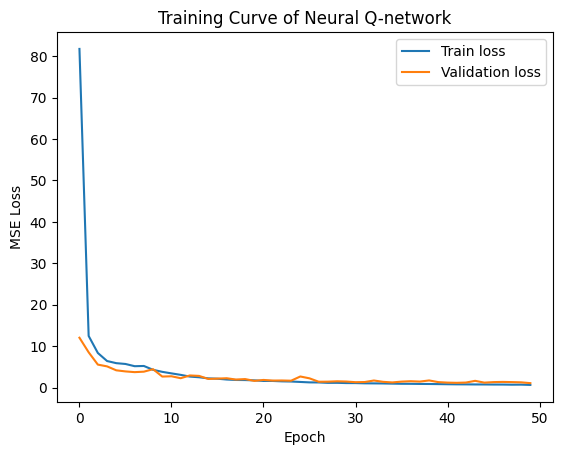

In [25]:
#training curve
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve of Neural Q-network")
plt.legend()
plt.show()


In [26]:
# Define a DL-based RL agent (continuous action)
def dl_agent_action(model, state):
    """
    Selects the best continuous action using a neural Q-network.
    Returns the action value (not an index).
    """
    q_values = []

    for a in action_list:
        sa = np.append(state, a).reshape(1, -1)
        q = model.predict(sa, verbose=0)[0][0]
        q_values.append(q)

    best_index = np.argmax(q_values)
    return action_list[best_index]

In [27]:
# Evaluate the DL-based RL agent (continuous action)
dl_preds = []

for s in X_test_states:
    a = dl_agent_action(dqn_model, s)  # a is already a strength value
    dl_preds.append(a)

dl_preds = np.array(dl_preds)

dl_mae = mean_absolute_error(y_test, dl_preds)
dl_mae

6.701799683995787

In [28]:
#Compare ALL approaches
comparison = {
    "Random Forest (Regression)": baseline_mae,
    "RL + XGBoost": rl_mae,
    "RL + Deep Learning": dl_mae
}

comparison


{'Random Forest (Regression)': 3.8263518903313516,
 'RL + XGBoost': 3.7917981253460837,
 'RL + Deep Learning': 6.701799683995787}

### Comparison Summary

- **Random Forest (Supervised Regression)** provides a strong and stable baseline
  for predicting compressive strength.

- **RL + XGBoost** reformulates prediction as a decision-making problem
  and achieves competitive accuracy while offering strong interpretability.

- **RL + Deep Learning** demonstrates that neural Q-function approximation
  is feasible in an offline setting, although it may require more data
  and tuning to outperform tree-based methods.

Overall, the reinforcement learning formulation provides a flexible framework
that bridges classical regression and decision-based modeling,
while maintaining competitive predictive performance.
